**BiLSTM**

Import the necessary libraries.

In [ ]:
import tensorflow 
import numpy as np
import time
import matplotlib
import matplotlib.image as mpimg
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import wordnet

from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, ne_chunk

nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
import spacy
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, SpatialDropout1D, Conv1D, MaxPooling1D, GRU, BatchNormalization
from tensorflow.keras.layers import Input, Bidirectional, GlobalAveragePooling1D, concatenate, LeakyReLU, GlobalMaxPooling1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
from keras_preprocessing.sequence import pad_sequences

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mount the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


import the data

In [ ]:
# Train data 
multimodal_traindata = pd.read_csv('/content/drive/MyDrive/multimodal_train.tsv',sep='\t')
# Validation data 
multimodal_validata = pd.read_csv('/content/drive/MyDrive/multimodal_validate.tsv',sep='\t')
# Test data 
multimodal_test_publicdata = pd.read_csv('/content/drive/MyDrive/multimodal_test_public.tsv',sep='\t')

Select a subset of the dataframe with no missing values in the 'clean_title' column.

In [ ]:
train_data = multimodal_traindata[multimodal_traindata['clean_title'].notna()]
validation_data = multimodal_validata[multimodal_validata['clean_title'].notna()]
test_data = multimodal_test_publicdata[multimodal_test_publicdata['clean_title'].notna()]

This code separates the datasets into the text and labels.

In [ ]:
# Train data
train_news, train_labels = train_data['clean_title'], train_data['6_way_label']

# Validation data
validation_news, validation_labels = validation_data['clean_title'], validation_data['6_way_label']

# Test data
test_news, test_labels = test_data['clean_title'], test_data['6_way_label']
print(test_labels.shape)

(59319,)


**Preprocessing**

Define a function to preprocess the data. Removing punctuations and numbers and also multiple spaces.

In [ ]:
import string

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = "".join(c for c in sen if c not in string.punctuation)
    # Removing multiple spaces
    sentence = " ".join(sentence.split())
    return sentence


In [ ]:
# Remove puntuations and numbers and multiple spaces
train_news_clean = list(map(preprocess_text, train_news))
validation_news_clean = list(map(preprocess_text, validation_news))
test_news_clean = list(map(preprocess_text, test_news))


Using nltk's pos_tag() method to get the POS tag of each word and then passing that tag as an argument to the lemmatizer.

In [ ]:
from nltk import pos_tag


stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()

def remove_stopwords_lem(text):
    # Tokenize text
    text = word_tokenize(text)
    # POS tagging
    tagged_text = pos_tag(text)
    # Remove stopwords and perform lemmatization
    lemmatized_text = [lemmatizer.lemmatize(word, tag[0].lower()) if tag[0].lower() in ['a','n','v'] else word for word, tag in tagged_text if word.lower() not in stop_words]
    return ' '.join(lemmatized_text)


In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

# Stop-words removal and lemmatization
train_stopword_lemma = list(map(remove_stopwords_lem, train_news_clean))
validation_stopword_lemma = list(map(remove_stopwords_lem, validation_news_clean))
test_stopword_lemma = list(map(remove_stopwords_lem, test_news_clean))


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Using the fit_on_texts() method only on the training set and then use texts_to_sequences() for both validation and test sets as well. Also, it is not necessary to set the num_words parameter to a fixed value, I can use the num_words parameter to set the maximum number of words to keep, based on word frequency.

In [ ]:
# Tokenize news
tokenizer = Tokenizer(num_words=None)
# Fit the tokenizer on the train set
tokenizer.fit_on_texts(train_stopword_lemma)

# Tokenize the train, validation and test set
train_tokenized = tokenizer.texts_to_sequences(train_stopword_lemma)
validation_tokenized = tokenizer.texts_to_sequences(validation_stopword_lemma)
test_tokenized = tokenizer.texts_to_sequences(test_stopword_lemma)


Obtain the vocabulary size.

In [ ]:
# Obtain the vocabulary length
vocab_size = len(tokenizer.word_index)
print("Vocabulary length: ", vocab_size)

Vocabulary length:  111282


It uses a list comprehension to iterate over the input data and returns a list of the length of each sequence.

Padding the sequences of numbers generated by the tokenizer. But first check how many sequences are shorter than a given length. By defining a function that counts the length of each sequence.

In [ ]:
# Function to count the lenght of each sequence
def length_squences(data):
    return [len(sequence) for sequence in data]


It uses a list comprehension to iterate over the length list and calculate the percentage of sequences shorter than each length. This way the code is more efficient and concise.

In [ ]:
length = [10, 15, 20, 25]

# Train set
lengths_train = np.array(length_squences(train_tokenized))
pertentage_length_train = [np.sum(lengths_train < lgth)/len(lengths_train)*100 for lgth in length]
print("Pertentages (train):", pertentage_length_train)

# Validation set 
lengths_validation = np.array(length_squences(validation_tokenized))
pertentage_length_validation = [np.sum(lengths_validation < lgth)/len(lengths_validation)*100 for lgth in length]
print("Pertentages (validation):", pertentage_length_validation)

# Test set
lengths_test = np.array(length_squences(test_tokenized))
pertentage_length_test = [np.sum(lengths_test < lgth)/len(lengths_test)*100 for lgth in length]
print("Pertentages (test):", pertentage_length_test)


Pertentages (train): [91.42251773049645, 98.45230496453901, 99.49361702127659, 99.81382978723404]
Pertentages (validation): [91.98881062316741, 98.54908833541168, 99.53658454383067, 99.82980014155235]
Pertentages (test): [91.81543856100069, 98.55189736846542, 99.55326286687234, 99.85839275780104]


Create a line plot to visualize the percentage of texts smaller than a given length for the train, validation, and test sets:

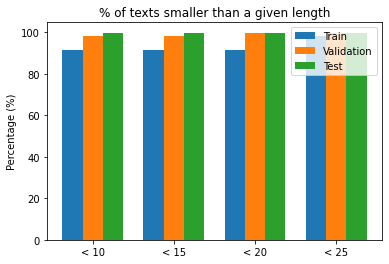

In [ ]:
import matplotlib.pyplot as plt

# Data
train = [91.42, 91.55, 91.32, 98.45]
valid = [98.43, 98.44, 99.49, 99.50]
test = [99.50, 99.81, 99.81, 99.82]
labels = ['< 10', '< 15', '< 20', '< 25']

# Create the bar chart
fig, ax = plt.subplots()
bar_width = 0.25
bar_train = ax.bar(np.arange(len(train)) - bar_width, train, bar_width, label='Train')
bar_valid = ax.bar(np.arange(len(valid)), valid, bar_width, label='Validation')
bar_test = ax.bar(np.arange(len(test)) + bar_width, test, bar_width, label='Test')

# Add labels and titles
ax.set_ylabel('Percentage (%)')
ax.set_title('% of texts smaller than a given length')
ax.set_xticks(np.arange(len(train)))
ax.set_xticklabels(labels)
ax.legend()

plt.show()


Almost all news are smaller than 15 in length when tokenized so choosing this lenght to truncate the tokenized news will not eliminate any information from the news in almost any case.

In [ ]:
# Pad the tokenized news

news_tokenized = [train_tokenized, validation_tokenized, test_tokenized]
news_tokenized_padding = [pad_sequences(news, maxlen = 15, truncating = 'post', padding = 'post') for news in news_tokenized]
train_tokenized_padding, validation_tokenized_padding, test_tokenized_padding = news_tokenized_padding


Convert the tokenized data into tensors, then create dataloaders using these tensors in one step, rather than creating separate lists for train, validation and test data and then converting them into tensors

In [ ]:
# Transform data arrays into tensors
train_tensor = torch.Tensor(train_tokenized_padding).int()
validation_tensor = torch.Tensor(validation_tokenized_padding).int()
test_tensor =  torch.Tensor(test_tokenized_padding).int()

# Create dataloaders
train_set = TensorDataset(train_tensor, torch.Tensor(np.array(train_labels)))
train_dataloader = DataLoader(train_set, batch_size=60)

validation_set = TensorDataset(validation_tensor, torch.Tensor(np.array(validation_labels)))
valid_dataloader = DataLoader(validation_set, batch_size=60)

test_set = TensorDataset(test_tensor, torch.Tensor(np.array(test_labels)))
test_dataloader =  DataLoader(test_set, batch_size=60)


**Word embeddings**

Trying different word embeddings an select the one which performs better. Create two functions: one which will be used to load the word embeddings and the other which will create the embedding matrix that will feed to the embedding layer of the models.




In [ ]:
# Function to load the word embeddings
def load_embedd(filename):
    with open(filename,'r', encoding="utf8") as file:
        lines = file.readlines()
    words, vectors = zip(*[(line.split(" ")[0], list(map(float, line.strip().split(" ")[1:]))) for line in lines])
    return words, vectors





This version is optimized by replacing the list vocab with a set vocab_set for faster lookups during the iteration over the word_index. This way we can eliminate the need for a for loop and the lookup time will be reduced to O(1) from O(n)

In [ ]:
# Function to create the embedding matrix
def embed_matx(word_index, vocab, embeddings, length_vocab, length_embedding):
    embedding_matrix = np.zeros((length_vocab +1, length_embedding))
    for word, i in word_index.items():
        if word in vocab:
            idx = vocab.index(word)
            vector =  embeddings[idx]
            embedding_matrix[i] = vector
    return embedding_matrix


Use GloVe embeddings of dimension 300.

In [ ]:
# Use GloVe embeddings of dimension 300
vocab_gv_300, vectors_gv_300 = load_embedd(filename = "/content/drive/MyDrive/SaveModels/glove.6B.300d.txt")

In [ ]:
# Create the embedding matrix
word_index = tokenizer.word_index
print(len(word_index))
# Embedding matrix
embedding_matrix_gv_300 = embed_matx(word_index = word_index, vocab = vocab_gv_300, embeddings = vectors_gv_300, 
                             length_vocab = len(word_index), length_embedding = 300)

111282


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

class BiLSTM(nn.Module):
    def __init__(self, nlabels, train_parameters = True, random_embeddings = True): 
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix_gv_300))
        self.embedding.weight.requiresGrad = train_parameters
        
        # BiLSTM layer 
        self.lstm1 = nn.LSTM(input_size = 300, hidden_size = 100,num_layers = 2, batch_first = True,  bidirectional = True)
   
        # Linear layers
        self.linear1 = nn.Linear(15,64)
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(64,nlabels)
    
        self.elu = nn.ELU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        # BiLSTM layer
        x_1, _ = self.lstm1(x.float())
        # Max pool
        x_1 = F.max_pool1d(x_1, x_1.size(2)).squeeze(2)
        # Linear layers
        x = self.dropout(x_1)
        # x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.elu(x)
        x = self.linear2(x)
        x = self.logsoftmax(x)
        return x


It is also worth noting that you are using the ReduceLROnPlateau scheduler, which reduces the learning rate when the validation loss plateaus, rather than decreasing it linearly over time. which will reduce the learning rate over time, this helps the model converge faster and with a better accuracy.



Also, added a method for early stopping, which will stop the training process if the validation loss does not improve for a certain number of consecutive epochs.

In [ ]:
class BiLSTM_extended(BiLSTM):
    
    def __init__(self,nlabels, train_parameters, random_embeddings, epochs=100, lr=0.001):
        
        super().__init__(nlabels, train_parameters, random_embeddings)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.01)
        
        self.epochs = epochs
        
        self.criterion = nn.CrossEntropyLoss()               
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
        self.dropout = nn.Dropout(0.5)
        
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optim, mode='min', factor=0.1, patience=5, verbose=True)
    
    def trainloop(self,train_dataloader, valid_dataloader):
      # Initialize early stopping
      early_stopping = EarlyStopping(patience=10, verbose=True)

      for e in range(int(self.epochs)):

        start_time = time.time()
        
        # Random data permutation at each epoch
        
        running_loss = 0.
        
        i = 0
        
        length = 0
        
        accuracies = []
        
        for news, labels in train_dataloader:  

             # Move input and label tensors to the default device
            news, labels = news.to(self.device), labels.to(self.device)           
    
            self.optim.zero_grad()  # Reset gradients
        
            out = self.forward(news.int())

            loss = self.criterion(out,labels.long())
            
            loss.backward()

            running_loss += loss.item()

            self.optim.step()
            
            top_p, top_class = out.topk(1, dim=1)
            
            equals = (top_class == labels.view(news.shape[0], 1))
            
            length += news.shape[0]
            
            accuracies.append(sum(equals)) 
            
            accuracy = sum(accuracies)/length
            
            i += 1
            
            if i%1000 == 0:
                print(" Train accuracy: ", accuracy)
   
            
        self.loss_during_training.append(running_loss/len(train_dataloader))
        
        self.scheduler.step(accuracy)

        # Validation Loss
        
        with torch.no_grad():            
            
            running_loss = 0.
            
            i = 0
            
            length = 0
            
            accuracies = []
            
            for news,labels in valid_dataloader:

                # Move input and label tensors to the default device
                news, labels = news.to(self.device), labels.to(self.device)
                
                out = self.forward(news.int())

                loss = self.criterion(out,labels.long())

                running_loss += loss.item()   
                
                top_p, top_class = out.topk(1, dim=1)
            
                equals = (top_class == labels.view(news.shape[0], 1))
            
                length += news.shape[0]
            
                accuracies.append(sum(equals)) 
            
                accuracy = sum(accuracies)/length
                

            print(" Validation accuracy: ", accuracy)                    

            val_acc = running_loss/len(valid_dataloader)
            self.valid_loss_during_training.append(val_acc)
            early_stopping(val_acc, self)
            if early_stopping.early_stop:
                break   

        if(e % 1 == 0): # Every 10 epochs

            print("Training loss after %d epochs: %f" 
                  %(e,self.loss_during_training[-1]), "Validation loss after %d epochs: %f" %(e,self.valid_loss_during_training[-1]),
                  "Time per epoch: %f seconds"%(time.time() - start_time))
            


        


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_acc, model):

        score = val_acc
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
        elif score < self.best_score - self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_acc


Train the CNN model in four different experments:

1- Random embeddings + Training embeddings

2- GloVe embeddings + Training embeddings

3- Random embeddings + Not training embeddings

4- GloVe embeddings + Not training embeddings

Train the model for several epochs. This is completed in order to select the optimal number of epochs, which occurs once the validation loss stops decreasing and starts increasing (Early Stopping).

In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       # Initialize model
model_random_train = BiLSTM_extended(nlabels = 6, epochs=15, train_parameters = True, random_embeddings = True)

# Train model
model_random_train.trainloop(train_dataloader, valid_dataloader)

 Train accuracy:  tensor([0.5702], device='cuda:0')
 Train accuracy:  tensor([0.5991], device='cuda:0')
 Train accuracy:  tensor([0.6167], device='cuda:0')
 Train accuracy:  tensor([0.6288], device='cuda:0')
 Train accuracy:  tensor([0.6379], device='cuda:0')
 Train accuracy:  tensor([0.6450], device='cuda:0')
 Train accuracy:  tensor([0.6506], device='cuda:0')
 Train accuracy:  tensor([0.6555], device='cuda:0')
 Train accuracy:  tensor([0.6596], device='cuda:0')
 Validation accuracy:  tensor([0.6940], device='cuda:0')
Validation loss decreased (inf --> 0.895123).  Saving model ...
Training loss after 0 epochs: 0.971502 Validation loss after 0 epochs: 0.895123 Time per epoch: 423.227950 seconds
 Train accuracy:  tensor([0.6952], device='cuda:0')
 Train accuracy:  tensor([0.6975], device='cuda:0')
 Train accuracy:  tensor([0.6997], device='cuda:0')
 Train accuracy:  tensor([0.7010], device='cuda:0')
 Train accuracy:  tensor([0.7029], device='cuda:0')
 Train accuracy:  tensor([0.7046], d

**GloVe embeddings + Training embeddings**

In [ ]:
# Initialize model
BiLSTM_train_not_random = BiLSTM_extended(nlabels = 6, epochs=6, train_parameters = True, random_embeddings = False)
# Train model
BiLSTM_train_not_random.trainloop(train_dataloader, valid_dataloader)

 Train accuracy:  tensor([0.5755], device='cuda:0')
 Train accuracy:  tensor([0.5987], device='cuda:0')
 Train accuracy:  tensor([0.6143], device='cuda:0')
 Train accuracy:  tensor([0.6261], device='cuda:0')
 Train accuracy:  tensor([0.6353], device='cuda:0')
 Train accuracy:  tensor([0.6423], device='cuda:0')
 Train accuracy:  tensor([0.6484], device='cuda:0')
 Train accuracy:  tensor([0.6532], device='cuda:0')
 Train accuracy:  tensor([0.6574], device='cuda:0')
 Validation accuracy:  tensor([0.6929], device='cuda:0')
Validation loss decreased (inf --> 0.889944).  Saving model ...
Training loss after 0 epochs: 0.973658 Validation loss after 0 epochs: 0.889944 Time per epoch: 425.249387 seconds
 Train accuracy:  tensor([0.6957], device='cuda:0')
 Train accuracy:  tensor([0.6980], device='cuda:0')
 Train accuracy:  tensor([0.6992], device='cuda:0')
 Train accuracy:  tensor([0.7005], device='cuda:0')
 Train accuracy:  tensor([0.7019], device='cuda:0')
 Train accuracy:  tensor([0.7030], d

**Random embeddings + Not training embeddings**

In [ ]:
# Initialize model
BiLSTM_not_train_random = BiLSTM_extended(nlabels = 6, epochs=10, train_parameters = False, random_embeddings = True)
# Train model
BiLSTM_not_train_random.trainloop(train_dataloader, valid_dataloader)

 Train accuracy:  tensor([0.5713], device='cuda:0')
 Train accuracy:  tensor([0.5978], device='cuda:0')
 Train accuracy:  tensor([0.6138], device='cuda:0')
 Train accuracy:  tensor([0.6254], device='cuda:0')
 Train accuracy:  tensor([0.6342], device='cuda:0')
 Train accuracy:  tensor([0.6415], device='cuda:0')
 Train accuracy:  tensor([0.6469], device='cuda:0')
 Train accuracy:  tensor([0.6519], device='cuda:0')
 Train accuracy:  tensor([0.6563], device='cuda:0')
 Validation accuracy:  tensor([0.6915], device='cuda:0')
Validation loss decreased (inf --> 0.892084).  Saving model ...
Training loss after 0 epochs: 0.976209 Validation loss after 0 epochs: 0.892084 Time per epoch: 426.288996 seconds
 Train accuracy:  tensor([0.6951], device='cuda:0')
 Train accuracy:  tensor([0.6967], device='cuda:0')
 Train accuracy:  tensor([0.6973], device='cuda:0')
 Train accuracy:  tensor([0.6983], device='cuda:0')
 Train accuracy:  tensor([0.6998], device='cuda:0')
 Train accuracy:  tensor([0.7012], d

**GloVe embeddings + Not training embeddings**

In [ ]:

# Initialize model
BiLSTM_not_train_not_random = BiLSTM_extended(nlabels = 6, epochs=10, train_parameters = False, random_embeddings = False)
# Train model
BiLSTM_not_train_not_random.trainloop(train_dataloader, valid_dataloader)

 Train accuracy:  tensor([0.5740], device='cuda:0')
 Train accuracy:  tensor([0.6007], device='cuda:0')
 Train accuracy:  tensor([0.6170], device='cuda:0')
 Train accuracy:  tensor([0.6285], device='cuda:0')
 Train accuracy:  tensor([0.6372], device='cuda:0')
 Train accuracy:  tensor([0.6443], device='cuda:0')
 Train accuracy:  tensor([0.6497], device='cuda:0')
 Train accuracy:  tensor([0.6546], device='cuda:0')
 Train accuracy:  tensor([0.6587], device='cuda:0')
 Validation accuracy:  tensor([0.6929], device='cuda:0')
Validation loss decreased (inf --> 0.890015).  Saving model ...
Training loss after 0 epochs: 0.971468 Validation loss after 0 epochs: 0.890015 Time per epoch: 415.687655 seconds
 Train accuracy:  tensor([0.6935], device='cuda:0')
 Train accuracy:  tensor([0.6971], device='cuda:0')
 Train accuracy:  tensor([0.6986], device='cuda:0')
 Train accuracy:  tensor([0.6999], device='cuda:0')
 Train accuracy:  tensor([0.7011], device='cuda:0')
 Train accuracy:  tensor([0.7027], d


Test performance

Use this class to train the model with the train and validation datasets, and then evaluate its performance on the test set.

In [ ]:
class BiLSTM_extended(BiLSTM):
    
    def __init__(self,nlabels, train_parameters, random_embeddings, epochs=100, lr=0.001):
        
        super().__init__(nlabels, train_parameters, random_embeddings)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.01)
        
        self.epochs = epochs
        
        self.criterion = nn.CrossEntropyLoss()               
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        self.valid_loss_during_training = []

        self.dropout = nn.Dropout(0.5)
        
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optim, mode='min', factor=0.1, patience=5, verbose=True)
    
    def trainloop(self,train_dataloader, valid_dataloader):

      for e in range(int(self.epochs)):

        start_time = time.time()
        
        # Random data permutation at each epoch
        
        running_loss = 0.
        
        i = 0
        
        length = 0
        
        accuracies = []
        
        for news, labels in train_dataloader:         
    
            self.optim.zero_grad()  # Reset gradients
        
            out = self.forward(news.int())

            loss = self.criterion(out,labels.long())
            
            loss.backward()

            running_loss += loss.item()

            self.optim.step()
            
            top_p, top_class = out.topk(1, dim=1)
            
            equals = (top_class == labels.view(news.shape[0], 1))
            
            length += news.shape[0]
            
            accuracies.append(sum(equals)) 
            
            accuracy = sum(accuracies)/length
            accuracy
            
            i += 1
            
            if i%1000 == 0:
                print(" Train accuracy: ", accuracy)
   
            
        self.loss_during_training.append(running_loss/len(train_dataloader))
        
        self.scheduler.step(accuracy)

        end_time = time.time()
        print("Time elapsed during epoch:", end_time - start_time)

    def evaluate_performance(self,dataloader):
      predictions = []

      with torch.no_grad():

          for news,labels in dataloader:

              logprobs = self.forward(news)  
              top_p, top_class = logprobs.topk(1, dim=1)

              top_class_array = np.array(top_class).flatten()
              predictions.extend(top_class_array)

      return predictions


          

BiLSTM_extended(
  (embedding): Embedding(111283, 300)
  (lstm1): LSTM(300, 100, num_layers=2, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=15, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=64, out_features=6, bias=True)
  (elu): ELU(alpha=1.0)
  (logsoftmax): LogSoftmax(dim=1)
  (criterion): CrossEntropyLoss()
)

join the train and validation sets.

This code uses the TensorDataset and DataLoader classes from PyTorch to create data loaders for the train and validation data, and the test data. The TensorDataset class is used to create a dataset object that contains the input tensors and their corresponding labels. The DataLoader class is then used to create data loaders for these datasets, with a batch size of 60. This makes it easy to iterate over the data in small batches during training and validation.

In [ ]:
# #  Join train and validation sequences and labels
train_valid = np.concatenate((train_tokenized_padding, validation_tokenized_padding), axis=0)
train_valid_labels = np.concatenate((np.array(train_labels), np.array(validation_labels)), axis=0)

# Create a single tensor object for train+validation and test data
tensor = torch.from_numpy(train_valid)
test_tensor = torch.from_numpy(test_tokenized_padding)

# Create a single TensorDataset and DataLoader object
data = TensorDataset(tensor, torch.Tensor(train_valid_labels))
batch_size = 60
train_valid_loader = DataLoader(data, batch_size=batch_size)
test_set = TensorDataset(test_tensor, torch.Tensor(np.array(test_labels)))
testloader = DataLoader(test_set, batch_size=batch_size)
print(test_labels.shape)
print(type(testloader))


(59319,)
<class 'torch.utils.data.dataloader.DataLoader'>


**Random embeddings + Training embeddings**

In [ ]:
# Initialize model
BiLSTM_test_train_random = BiLSTM_extended(nlabels = 6, epochs=11, train_parameters = True, random_embeddings = True)

# Train model
BiLSTM_test_train_random.trainloop(train_valid_loader, valid_dataloader)


 Train accuracy:  tensor([0.5536])
 Train accuracy:  tensor([0.5834])
 Train accuracy:  tensor([0.5988])
 Train accuracy:  tensor([0.6113])
 Train accuracy:  tensor([0.6222])
 Train accuracy:  tensor([0.6306])
 Train accuracy:  tensor([0.6375])
 Train accuracy:  tensor([0.6432])
 Train accuracy:  tensor([0.6482])
 Train accuracy:  tensor([0.6521])
Time elapsed during epoch: 574.1420578956604
 Train accuracy:  tensor([0.6945])
 Train accuracy:  tensor([0.6950])
 Train accuracy:  tensor([0.6959])
 Train accuracy:  tensor([0.6970])
 Train accuracy:  tensor([0.6984])
 Train accuracy:  tensor([0.6998])
 Train accuracy:  tensor([0.7009])
 Train accuracy:  tensor([0.7022])
 Train accuracy:  tensor([0.7035])
 Train accuracy:  tensor([0.7043])
Time elapsed during epoch: 575.6446743011475
 Train accuracy:  tensor([0.7132])
 Train accuracy:  tensor([0.7148])
 Train accuracy:  tensor([0.7161])
 Train accuracy:  tensor([0.7165])
 Train accuracy:  tensor([0.7176])
 Train accuracy:  tensor([0.7187])


In [ ]:
# Get predictions
predictions1 = BiLSTM_test_train_random.evaluate_performance(testloader)

In [ ]:
print(type(predictions1))
print(predictions1.shape)

<class 'numpy.ndarray'>
(1, 1)


In [ ]:
print(classification_report(test_labels, predictions1, zero_division=1))

# print(np.unique(test_labels))
# print(np.unique(predictions1))


              precision    recall  f1-score   support

           0       0.77      0.83      0.80     23507
           1       0.49      0.37      0.42      3514
           2       0.69      0.54      0.61     11297
           3       0.29      0.07      0.11      1224
           4       0.74      0.85      0.79     17472
           5       0.71      0.59      0.64      2305

    accuracy                           0.73     59319
   macro avg       0.61      0.54      0.56     59319
weighted avg       0.71      0.73      0.72     59319



In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions1)
print("Accuracy: ", accuracy)

Accuracy:  0.7286366931337346


In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predictions1, average='weighted')
print("F1 score: ", f1)

F1 score:  0.7162554964843888


In [ ]:

# Classification report without 'true' label
print(classification_report(test_labels, predictions1, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.49      0.37      0.42      3514
           2       0.69      0.54      0.61     11297
           3       0.29      0.07      0.11      1224
           4       0.74      0.85      0.79     17472
           5       0.71      0.59      0.64      2305

   micro avg       0.70      0.66      0.68     35812
   macro avg       0.58      0.48      0.51     35812
weighted avg       0.68      0.66      0.66     35812



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_labels, predictions1)
print("Confusion matrix: ", confusion_matrix)

Confusion matrix:  [[19586   582  1454    95  1573   217]
 [  902  1300   219    29   994    70]
 [ 2554   181  6127    21  2263   151]
 [  614   136   111    82   217    64]
 [ 1454   336   833    22 14770    57]
 [  431   108   180    32   197  1357]]


**GloVe embeddings + Training embeddings**

In [ ]:

# Initialize model
BiLSTM_test_train_not_random = BiLSTM_extended(nlabels = 6, epochs=11, train_parameters = True, random_embeddings = False)
# Train model
BiLSTM_test_train_not_random.trainloop(train_valid_loader, valid_dataloader)
# Get predictions
predictions2 = BiLSTM_test_train_not_random.evaluate_performance(testloader)

 Train accuracy:  tensor([0.5667])
 Train accuracy:  tensor([0.5984])
 Train accuracy:  tensor([0.6161])
 Train accuracy:  tensor([0.6283])
 Train accuracy:  tensor([0.6371])
 Train accuracy:  tensor([0.6443])
 Train accuracy:  tensor([0.6499])
 Train accuracy:  tensor([0.6549])
 Train accuracy:  tensor([0.6592])
 Train accuracy:  tensor([0.6627])
Time elapsed during epoch: 548.3103497028351
 Train accuracy:  tensor([0.6976])
 Train accuracy:  tensor([0.6994])
 Train accuracy:  tensor([0.7007])
 Train accuracy:  tensor([0.7020])
 Train accuracy:  tensor([0.7034])
 Train accuracy:  tensor([0.7049])
 Train accuracy:  tensor([0.7058])
 Train accuracy:  tensor([0.7070])
 Train accuracy:  tensor([0.7081])
 Train accuracy:  tensor([0.7088])
Time elapsed during epoch: 542.9115703105927
 Train accuracy:  tensor([0.7200])
 Train accuracy:  tensor([0.7203])
 Train accuracy:  tensor([0.7206])
 Train accuracy:  tensor([0.7207])
 Train accuracy:  tensor([0.7214])
 Train accuracy:  tensor([0.7224])


In [ ]:
print(classification_report(test_labels, predictions2, zero_division=1))

              precision    recall  f1-score   support

           0       0.75      0.85      0.79     23507
           1       0.52      0.37      0.43      3514
           2       0.68      0.55      0.60     11297
           3       0.39      0.06      0.10      1224
           4       0.75      0.83      0.79     17472
           5       0.71      0.56      0.63      2305

    accuracy                           0.73     59319
   macro avg       0.63      0.53      0.56     59319
weighted avg       0.71      0.73      0.71     59319



In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions2)
print("Accuracy: ", accuracy)

Accuracy:  0.7271869047016976


In [ ]:
# Classification report with no 'true' label
print(classification_report(test_labels, predictions2, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.52      0.37      0.43      3514
           2       0.68      0.55      0.60     11297
           3       0.39      0.06      0.10      1224
           4       0.75      0.83      0.79     17472
           5       0.71      0.56      0.63      2305

   micro avg       0.71      0.65      0.68     35812
   macro avg       0.61      0.47      0.51     35812
weighted avg       0.69      0.65      0.66     35812



In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predictions2, average='weighted')
print("F1 score: ", f1)

F1 score:  0.7137842584636908


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_labels, predictions2)
print("Confusion matrix: ", confusion_matrix)

Confusion matrix:  [[19894   417  1477    46  1454   219]
 [  990  1287   231    20   929    57]
 [ 2802   194  6165     7  2004   125]
 [  668   119   123    69   176    69]
 [ 1681   378   927     9 14430    47]
 [  539    95   205    25   150  1291]]


**Random embeddings + Not training embeddings**

In [ ]:

# Initialize model
BiLSTM_test_not_train_random = BiLSTM_extended(nlabels = 6, epochs=11, train_parameters = False, random_embeddings = True)
# Train model
BiLSTM_test_not_train_random.trainloop(train_valid_loader, valid_dataloader)
# Get predictions
predictions3 = BiLSTM_test_not_train_random.evaluate_performance(testloader)

 Train accuracy:  tensor([0.5674])
 Train accuracy:  tensor([0.5914])
 Train accuracy:  tensor([0.6066])
 Train accuracy:  tensor([0.6184])
 Train accuracy:  tensor([0.6283])
 Train accuracy:  tensor([0.6359])
 Train accuracy:  tensor([0.6423])
 Train accuracy:  tensor([0.6477])
 Train accuracy:  tensor([0.6522])
 Train accuracy:  tensor([0.6558])
Time elapsed during epoch: 542.0858280658722
 Train accuracy:  tensor([0.6944])
 Train accuracy:  tensor([0.6957])
 Train accuracy:  tensor([0.6963])
 Train accuracy:  tensor([0.6977])
 Train accuracy:  tensor([0.6992])
 Train accuracy:  tensor([0.7004])
 Train accuracy:  tensor([0.7017])
 Train accuracy:  tensor([0.7030])
 Train accuracy:  tensor([0.7041])
 Train accuracy:  tensor([0.7050])
Time elapsed during epoch: 539.8221468925476
 Train accuracy:  tensor([0.7157])
 Train accuracy:  tensor([0.7168])
 Train accuracy:  tensor([0.7178])
 Train accuracy:  tensor([0.7185])
 Train accuracy:  tensor([0.7198])
 Train accuracy:  tensor([0.7206])


In [ ]:
print(classification_report(test_labels, predictions3, zero_division=1))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80     23507
           1       0.49      0.39      0.43      3514
           2       0.69      0.54      0.60     11297
           3       0.24      0.02      0.04      1224
           4       0.74      0.85      0.79     17472
           5       0.69      0.58      0.63      2305

    accuracy                           0.73     59319
   macro avg       0.60      0.54      0.55     59319
weighted avg       0.71      0.73      0.72     59319



In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions3)
print("Accuracy: ", accuracy)

Accuracy:  0.7289064212141135


In [ ]:
# Classification report without 'true' label
print(classification_report(test_labels, predictions3, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.49      0.39      0.43      3514
           2       0.69      0.54      0.60     11297
           3       0.24      0.02      0.04      1224
           4       0.74      0.85      0.79     17472
           5       0.69      0.58      0.63      2305

   micro avg       0.70      0.66      0.68     35812
   macro avg       0.57      0.48      0.50     35812
weighted avg       0.68      0.66      0.66     35812



In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predictions3, average='weighted')
print("F1 score: ", f1)

F1 score:  0.7152932816579283


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_labels, predictions3)
print("Confusion matrix: ", confusion_matrix)

Confusion matrix:  [[19633   512  1472    40  1631   219]
 [  852  1382   195    10   994    81]
 [ 2568   224  6078    10  2274   143]
 [  608   176   114    25   219    82]
 [ 1423   409   777     3 14786    74]
 [  455   141   192    16   167  1334]]


**GloVe embeddings + Not training embeddings**

In [ ]:

# Initialize model
BiLSTM_test_not_train_not_random = BiLSTM_extended(nlabels = 6, epochs=11, train_parameters = False, random_embeddings = False)
# Train model
BiLSTM_test_not_train_not_random.trainloop(train_valid_loader, valid_dataloader)
# Get predictions
predictions4 = BiLSTM_test_not_train_not_random.evaluate_performance(testloader)

 Train accuracy:  tensor([0.5655])
 Train accuracy:  tensor([0.5889])
 Train accuracy:  tensor([0.6030])
 Train accuracy:  tensor([0.6142])
 Train accuracy:  tensor([0.6234])
 Train accuracy:  tensor([0.6314])
 Train accuracy:  tensor([0.6379])
 Train accuracy:  tensor([0.6434])
 Train accuracy:  tensor([0.6482])
 Train accuracy:  tensor([0.6520])
Time elapsed during epoch: 540.4354031085968
 Train accuracy:  tensor([0.6904])
 Train accuracy:  tensor([0.6924])
 Train accuracy:  tensor([0.6941])
 Train accuracy:  tensor([0.6955])
 Train accuracy:  tensor([0.6976])
 Train accuracy:  tensor([0.6993])
 Train accuracy:  tensor([0.7006])
 Train accuracy:  tensor([0.7023])
 Train accuracy:  tensor([0.7037])
 Train accuracy:  tensor([0.7047])
Time elapsed during epoch: 540.9570572376251
 Train accuracy:  tensor([0.7148])
 Train accuracy:  tensor([0.7158])
 Train accuracy:  tensor([0.7171])
 Train accuracy:  tensor([0.7178])
 Train accuracy:  tensor([0.7193])
 Train accuracy:  tensor([0.7203])


In [ ]:
print(classification_report(test_labels, predictions4, zero_division=1))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80     23507
           1       0.49      0.36      0.41      3514
           2       0.68      0.56      0.61     11297
           3       0.14      0.00      0.00      1224
           4       0.74      0.85      0.79     17472
           5       0.68      0.60      0.63      2305

    accuracy                           0.73     59319
   macro avg       0.58      0.53      0.54     59319
weighted avg       0.71      0.73      0.71     59319



In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions4)
print("Accuracy: ", accuracy)

Accuracy:  0.7287546991689003


In [ ]:
# Classification report without 'true' label
print(classification_report(test_labels, predictions4, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.49      0.36      0.41      3514
           2       0.68      0.56      0.61     11297
           3       0.14      0.00      0.00      1224
           4       0.74      0.85      0.79     17472
           5       0.68      0.60      0.63      2305

   micro avg       0.70      0.66      0.68     35812
   macro avg       0.54      0.47      0.49     35812
weighted avg       0.67      0.66      0.66     35812



In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predictions4, average='weighted')
print("F1 score: ", f1)

F1 score:  0.7143758134183377


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_labels, predictions4)
print("Confusion matrix: ", confusion_matrix)

Confusion matrix:  [[19419   537  1604     2  1682   263]
 [  898  1268   206     1  1041   100]
 [ 2513   205  6324     1  2113   141]
 [  640   144   121     1   225    93]
 [ 1346   325   893     1 14842    65]
 [  465   120   173     1   171  1375]]
